<a href="https://colab.research.google.com/github/cedro3/GFPGAN/blob/master/GFPGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
7#@title #**setup**

# --- GFPGAN setup ---
# Clone GFPGAN
%cd /content
!rm -rf GFPGAN
!git clone https://github.com/cedro3/GFPGAN.git
%cd GFPGAN

# install library
!pip install basicsr
!pip install facexlib
!pip install -r requirements.txt
!python setup.py develop
!pip install realesrgan  

# Download the pre-trained model
!wget https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth -P experiments/pretrained_models

# add function
from function import display_pic, reset_folder, comp_display


# --- DeOldify setup ---
# Clone DeOldify
%cd /content
!rm -rf DeOldify
!git clone https://github.com/jantic/DeOldify.git
%cd DeOldify

#NOTE:  This must be the first call in order to work properly!
from deoldify import device
from deoldify.device_id import DeviceId

#choices:  CPU, GPU0...GPU7
device.set(device=DeviceId.GPU0)
import torch
if not torch.cuda.is_available():
    print('GPU not available.')

# install library
! pip install -r colab_requirements.txt

# import library
import fastai
from deoldify.visualize import *
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*?Your .*? set is empty.*?")

# download models
! mkdir 'models'
! wget https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth -O ./models/ColorizeArtistic_gen.pth

# download watermark
! wget https://media.githubusercontent.com/media/jantic/DeOldify/master/resource_images/watermark.png -O ./resource_images/watermark.png

# load model
colorizer = get_image_colorizer(artistic=True)


/content
Cloning into 'GFPGAN'...
remote: Enumerating objects: 474, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 474 (delta 12), reused 34 (delta 4), pack-reused 426
Receiving objects: 100% (474/474), 7.27 MiB | 33.86 MiB/s, done.
Resolving deltas: 100% (226/226), done.
/content/GFPGAN
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 161 kB 7.6 MB/s 
     |████████████████████████████████| 5.8 MB 67.5 MB/s 
     |████████████████████████████████| 190 kB 70.6 MB/s 
  Created wheel for basicsr: filename=basicsr-1.3.5-py3-none-any.whl size=194482 sha256=07cdd85f01eea4080105b37ee0e65c2f717e9e5812a8a2045614a4a15af2b326
  Stored in directory: /root/.cache/pip/wheels/74/1b/d0/8659cf028233dd1e3bf282271009fbf037dfc4ab761f32a032
Successfully built basicsr
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/

running develop
running egg_info
creating gfpgan.egg-info
writing gfpgan.egg-info/PKG-INFO
writing dependency_links to gfpgan.egg-info/dependency_links.txt
writing requirements to gfpgan.egg-info/requires.txt
writing top-level names to gfpgan.egg-info/top_level.txt
writing manifest file 'gfpgan.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'gfpgan.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/gfpgan.egg-link (link to .)
Adding gfpgan 1.3.2 to easy-install.pth file

Installed /content/GFPGAN
Processing dependencies for gfpgan==1.3.2
Searching for yapf==0.32.0
Best match: yapf 0.32.0
Adding yapf 0.32.0 to easy-install.pth file
Installing yapf script to /usr/local/bin
Installing yapf-diff script to /usr/local/bin

Using /usr/local/lib/python3.7/dist-packages
Searching for tqdm==4.64.0
Best match: tqdm 4.64.0
Adding tqdm 4.64.0 to easy-install.pth file
Installing tqdm script to /us

--2022-06-12 03:50:38--  https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255144681 (243M) [application/octet-stream]
Saving to: ‘./models/ColorizeArtistic_gen.pth’

./models/ColorizeAr 100%[===================>] 243.32M  20.7MB/s    in 13s     

2022-06-12 03:50:51 (19.3 MB/s) - ‘./models/ColorizeArtistic_gen.pth’ saved [255144681/255144681]

--2022-06-12 03:50:51--  https://media.githubusercontent.com/media/jantic/DeOldify/master/resource_images/watermark.png
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9210 (9.0K) [image/png]
Saving to: ‘./

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

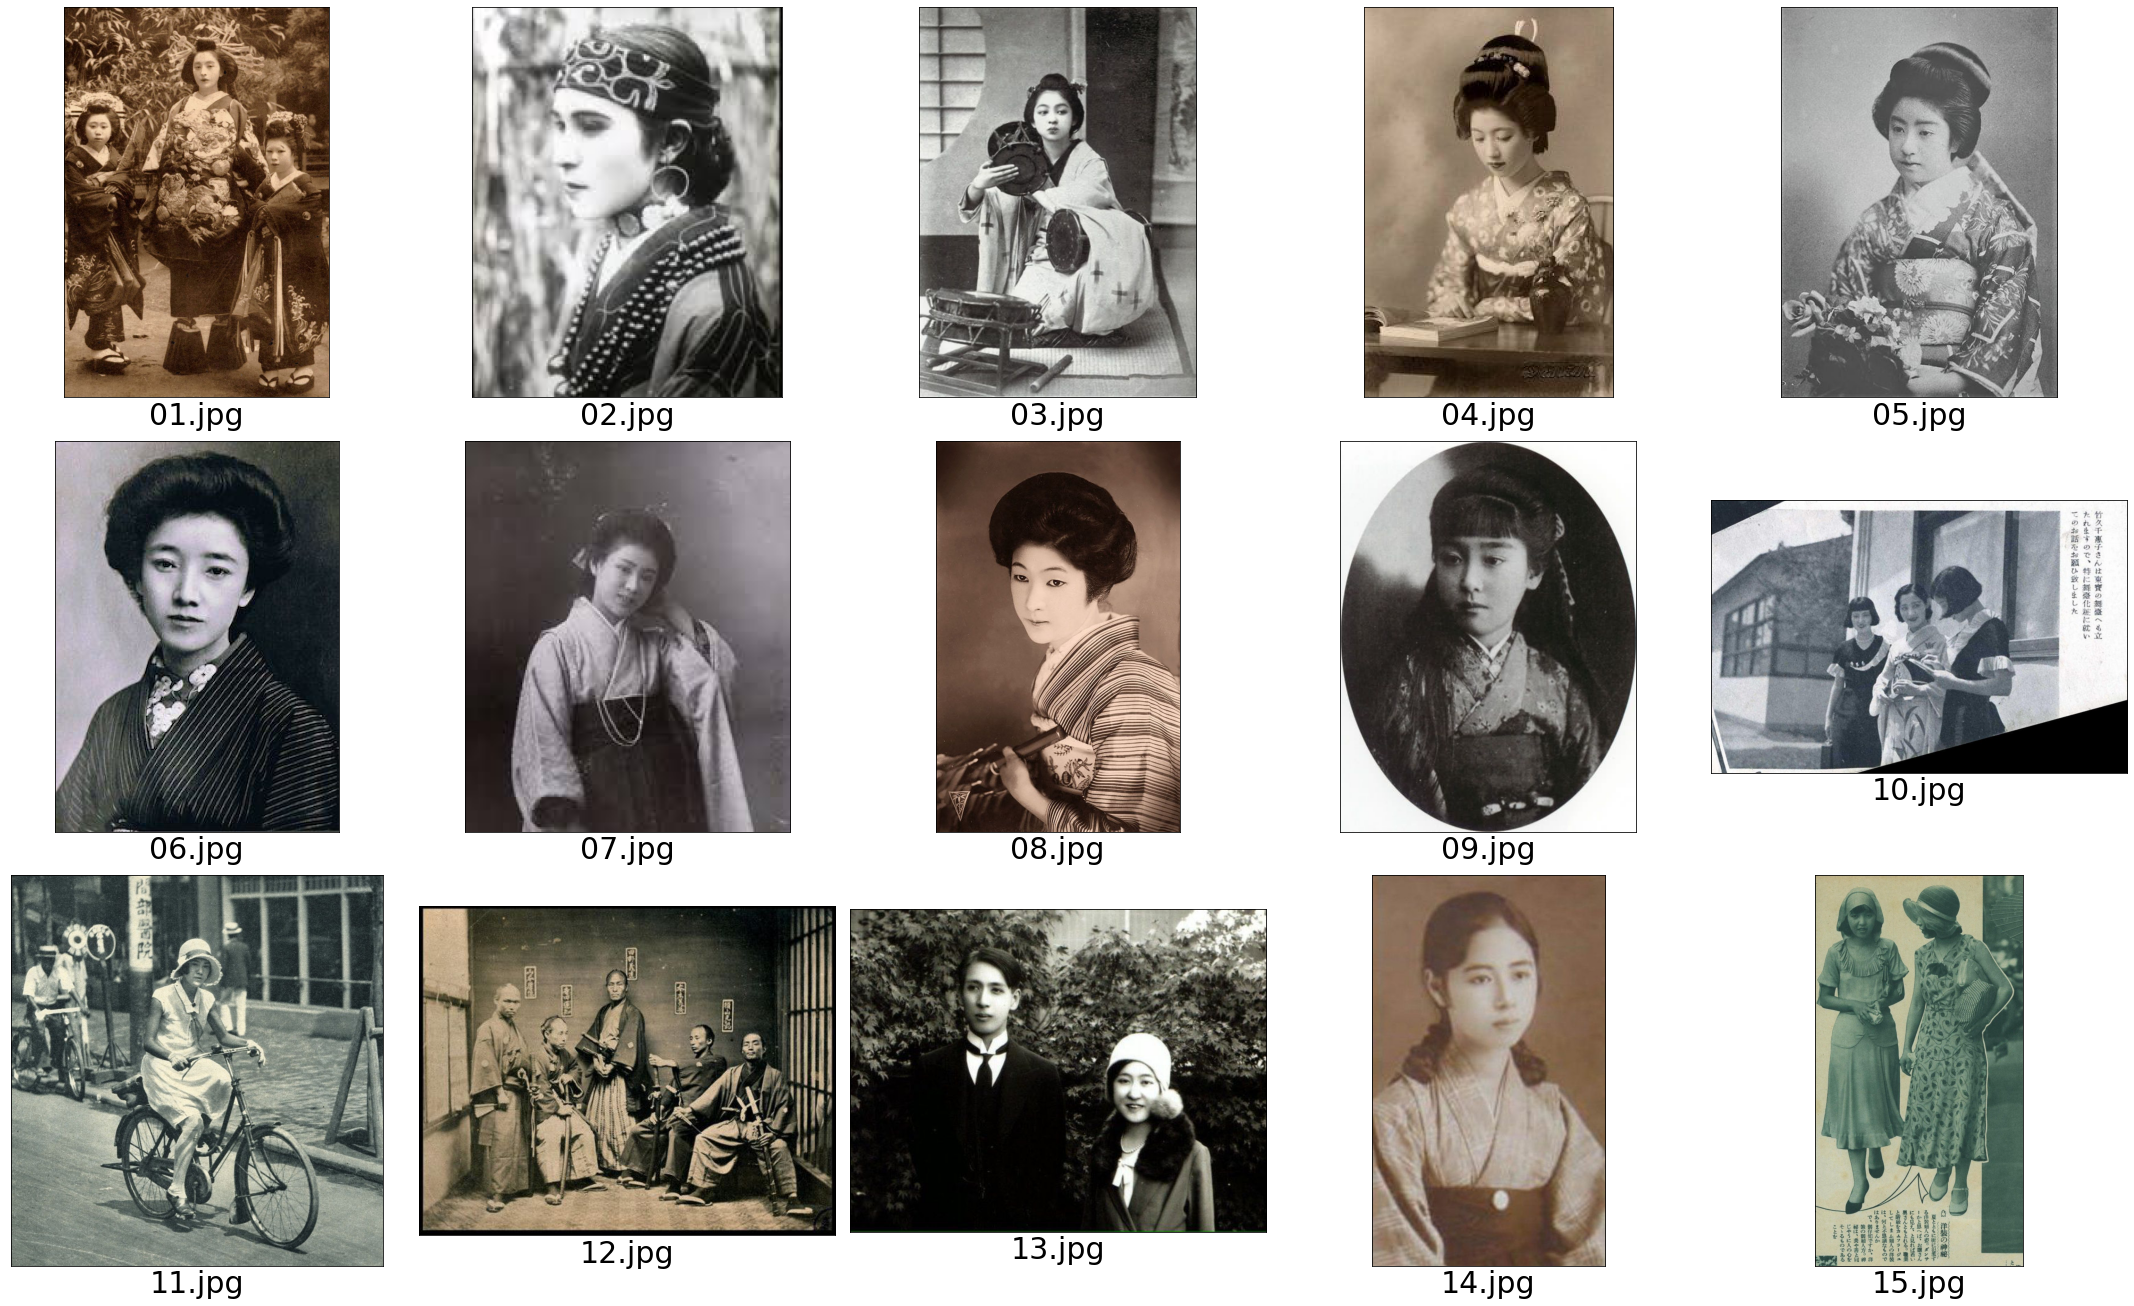

In [2]:
#@title #**display sample picture**
display_pic('/content/GFPGAN/images')

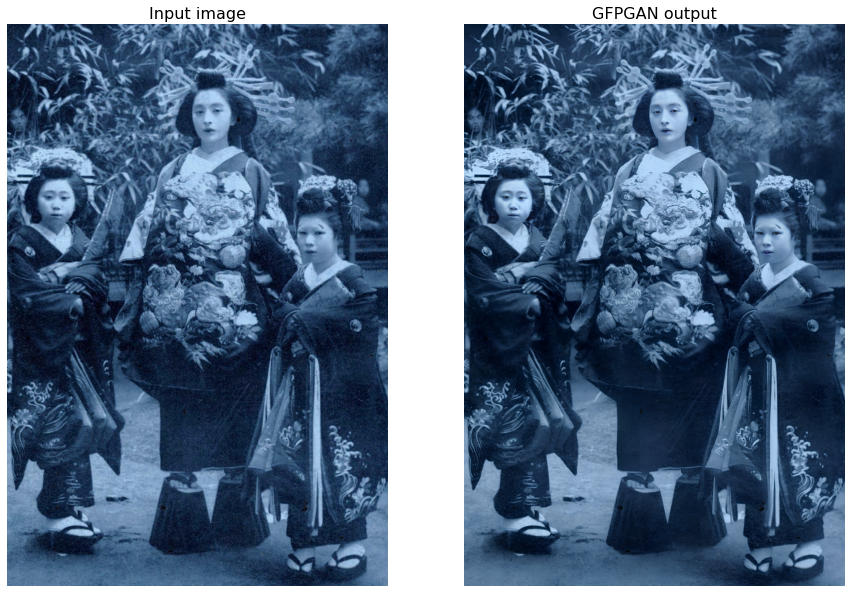

In [17]:
#@title #**GFPGAN**
%cd /content/GFPGAN
!rm -rf results
picture = '09.jpg'#@param {type:"string"}
input_path = 'images/'+ picture

!python inference_gfpgan.py -i $input_path -o results -v 1.3 -s 2 --bg_upsampler realesrgan

# display befor & after
from IPython.display import clear_output
clear_output()
img_input = cv2.imread('images/'+picture)
img_output = cv2.imread('results/restored_imgs/'+picture)
comp_display(img_input, img_output)

/content/DeOldify


PosixPath('result_images/01.jpg')

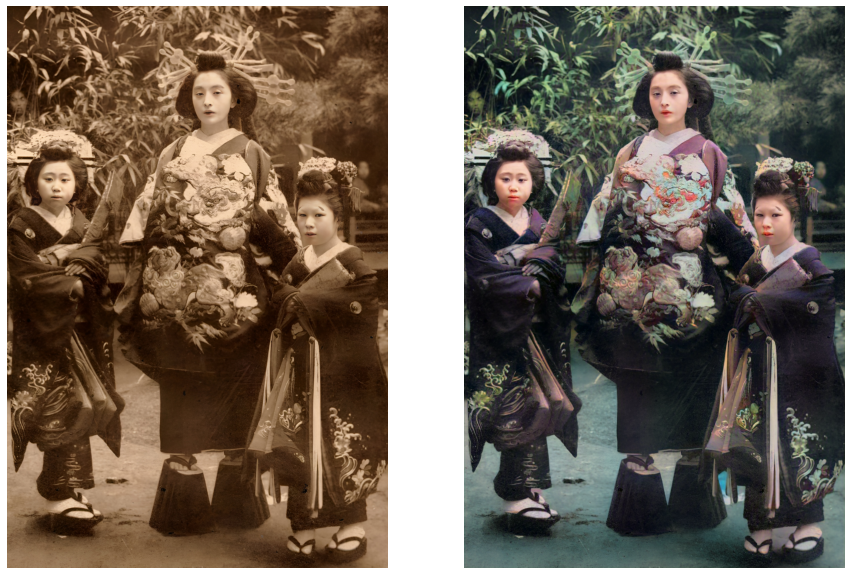

In [18]:
#@title #**DeOldify**

# copy image
%cd /content/DeOldify
import shutil

pic = '/content/GFPGAN/results/restored_imgs/'+picture
dst_pic = '/content/DeOldify/test_images/'+picture
shutil.copy(pic, dst_pic)


# DeOldify
file_path = 'test_images/'+picture
render_factor = 35 

colorizer.plot_transformed_image(file_path,\
                                  render_factor= render_factor,\
                                  watermarked = False,\
                                  display_render_factor=False,\
                                  compare=True,\
                                  figsize=(15,15))

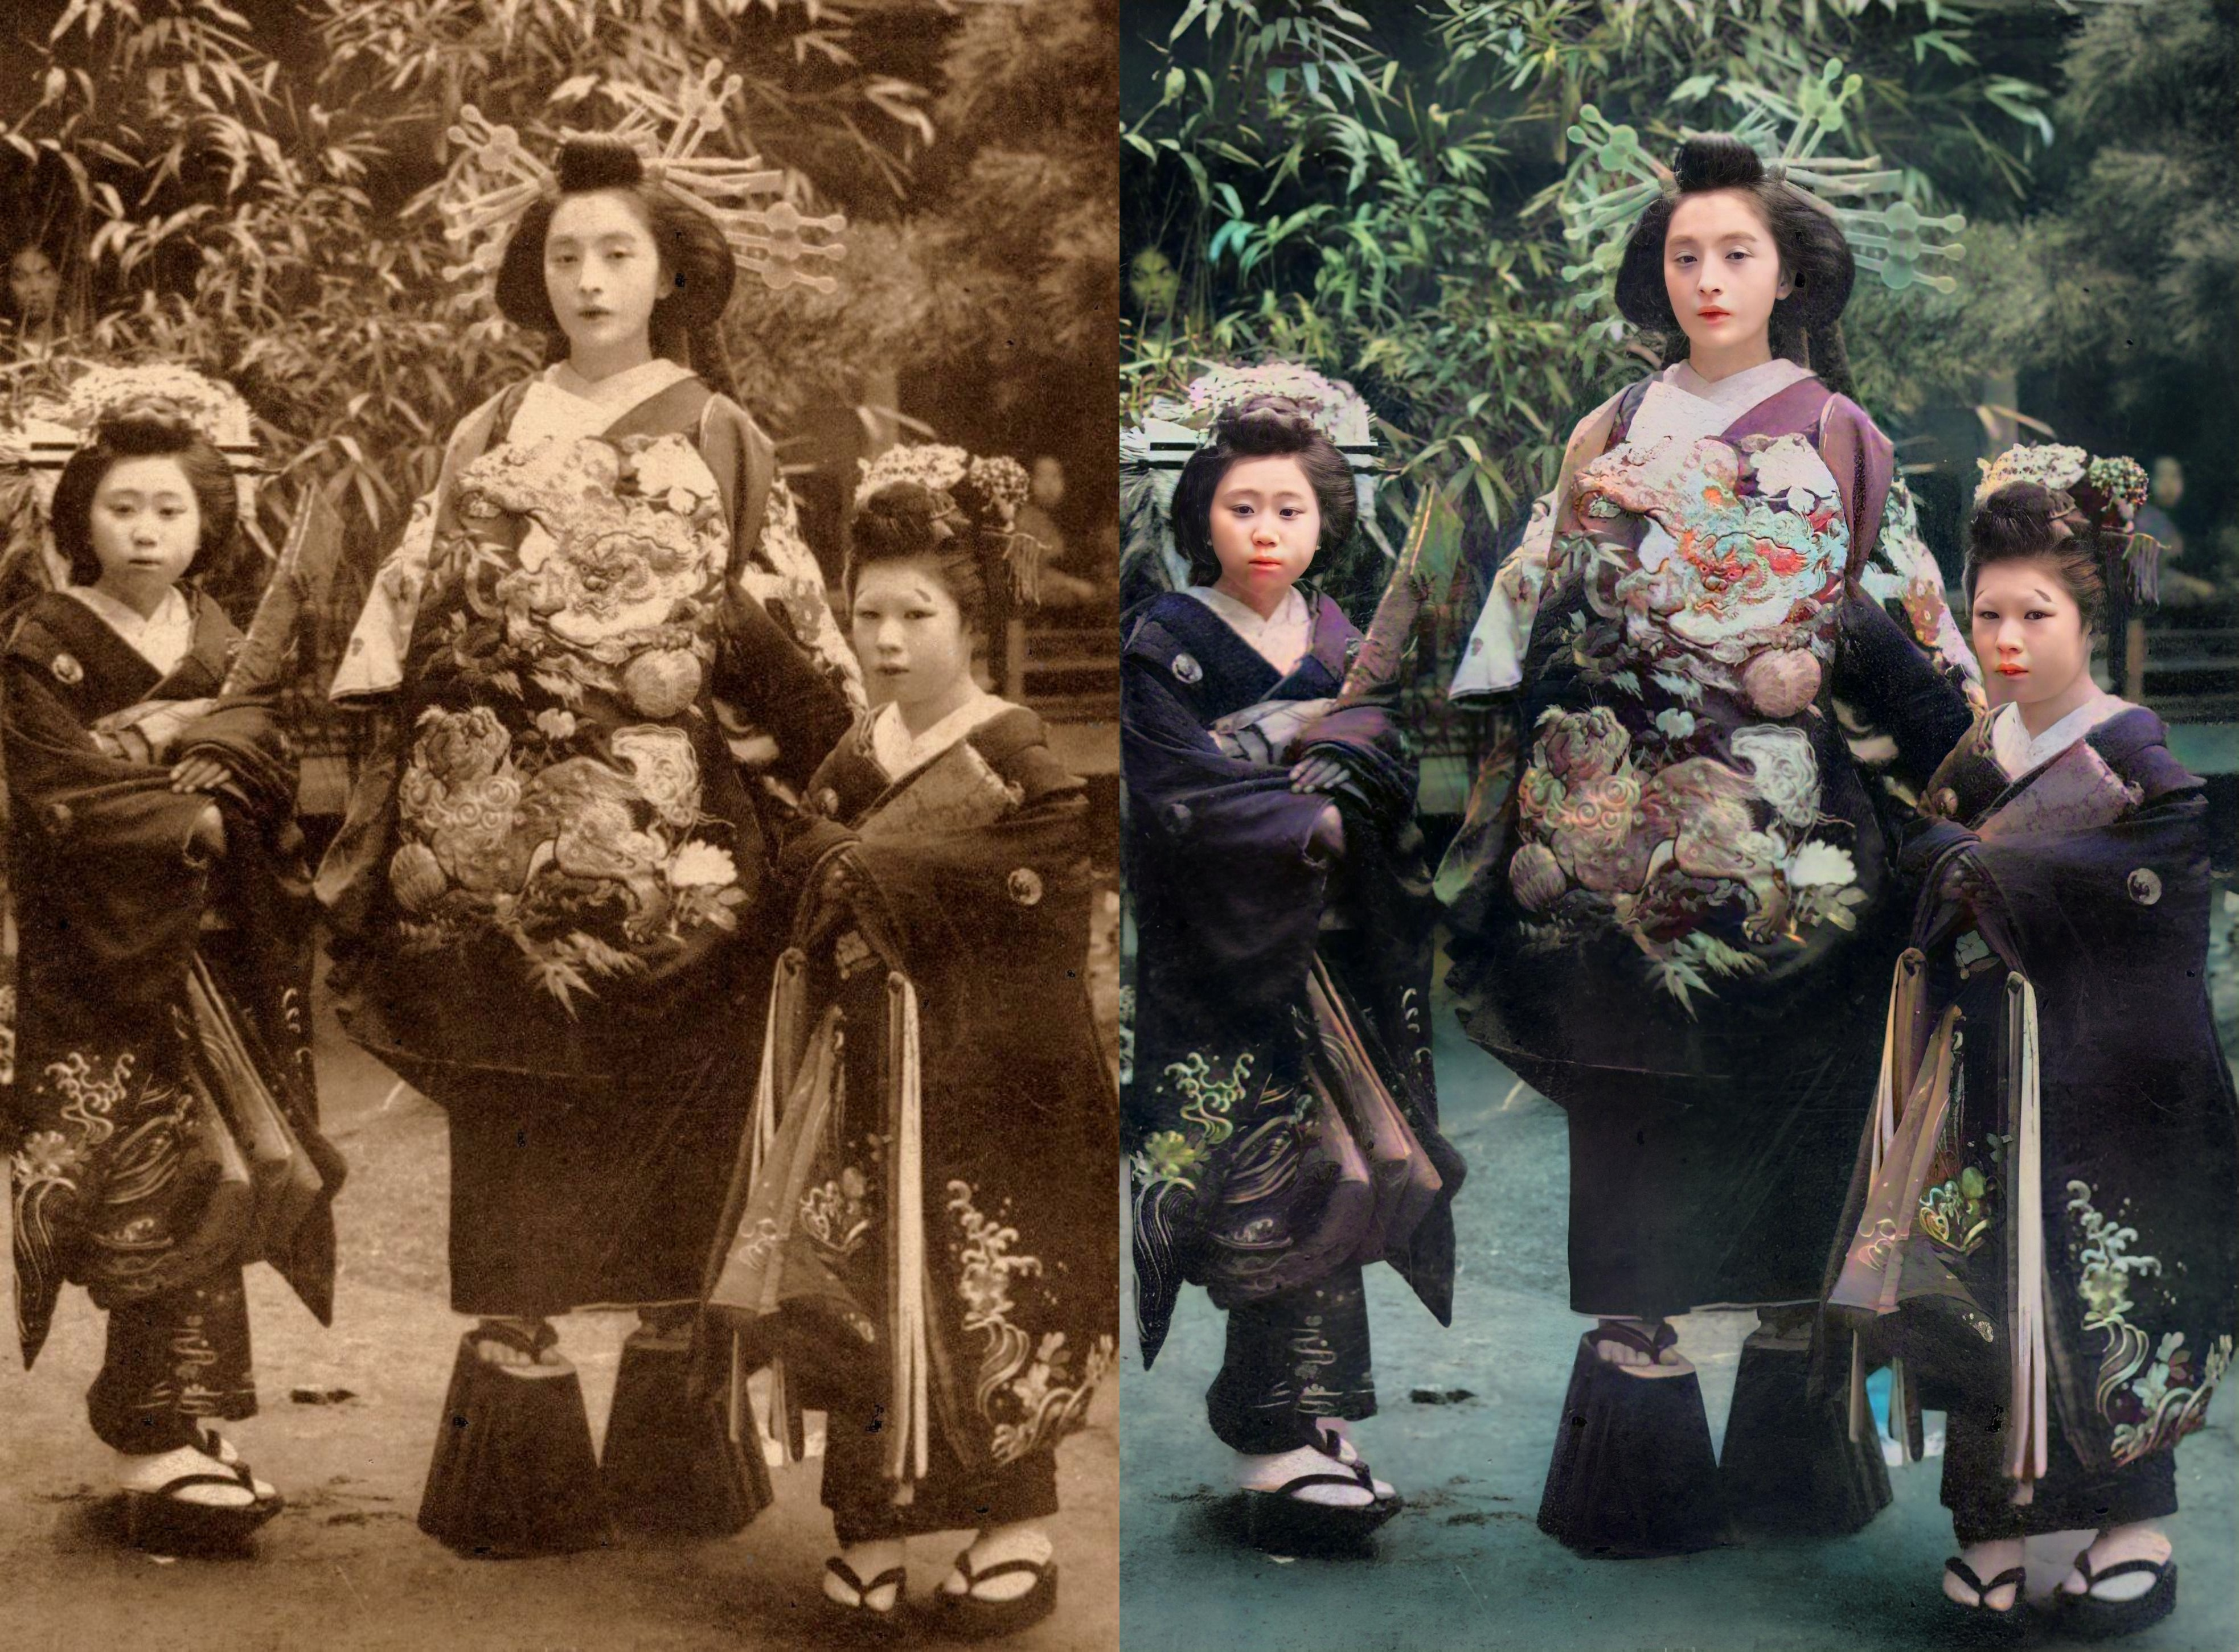

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
#@title #**final comparison image**

# concatenate pre-conversion and post-conversion images
reset_folder('compare_images')
mono = cv2.imread('/content/GFPGAN/images/'+picture)
tmp = cv2.imread('/content/GFPGAN/results/restored_imgs/'+picture)
color = cv2.imread('/content/DeOldify/result_images/'+picture)
height, width ,channels =tmp.shape
mono = cv2.resize(mono, dsize=(width, height))
color = cv2.resize(color, dsize=(width, height))

if height > width:
  result = cv2.hconcat([mono, color])
else:
  result = cv2.vconcat([color, mono])  
cv2.imwrite('compare_images/fine'+picture, result)

# display
from IPython.display import display
from IPython.display import Image as show_img
display(show_img('compare_images/fine'+picture))

# auto-download
from google.colab import files
files.download('compare_images/fine'+picture)